<a href="https://colab.research.google.com/github/ngohienduong/WQU-Econ/blob/main/W5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE 610 Econometrics (C22-S1) - Groupwork Assignment Submission 2 M5

In [29]:
!pip install yfinance


### Impoting required libraries

In [30]:
import warnings
from IPython.display import Image
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.api as sm
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [31]:
warnings.filterwarnings('ignore')
%matplotlib inline
rcParams['figure.figsize'] = 20,10

### Step 0: Selecting a data set

For gold ETF, we choose SPDR Gold Trust (GLD) and for non-US equity ETF, we choose: iShares MSCI Emerging Markets ETF (EEM). We also pull data for Grayscale Bitcoin Trust (GBTC).

### Step 1: Data Importing

We consider three time points for splitting the pulled data:

In [32]:
Apr20 = dt.datetime(2020,4,1)
Jul20 = dt.datetime(2020,7,1)
Oct20 = dt.datetime(2020,10,1)
Jan21 = dt.datetime(2021,1,1)

#### Gold ETF (GLD):

In [33]:
GLD = yf.download('GLD',start = Apr20, end = Jan21,  progress = False)
GLD[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,148.199997,150.080002,147.850006,149.449997,149.449997,11827400
2020-04-02,151.199997,152.500000,150.699997,151.899994,151.899994,9188300
2020-04-03,152.229996,153.089996,151.660004,152.649994,152.649994,8469100
2020-04-06,154.160004,157.220001,153.960007,156.880005,156.880005,14739300
2020-04-07,155.330002,156.139999,154.380005,156.039993,156.039993,9195400


#### Emerging Markets ETF (EEM):

In [34]:
EEM = yf.download('EEM', start = Apr20, end = Jan21, progress = False)
EEM[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,33.099998,33.330002,32.619999,32.669998,31.540220,65580600
2020-04-02,33.290001,33.939999,33.200001,33.770000,32.602184,55784000
2020-04-03,33.689999,33.860001,32.950001,33.130001,31.984318,68672500
2020-04-06,34.439999,34.950001,34.299999,34.939999,33.731724,82394800
2020-04-07,36.090000,36.119999,35.049999,35.119999,33.905502,74322600


#### Bitcoin (BTC):

In [35]:
GBTC = yf.download('GBTC', start = Apr20, end = Jan21, progress = False)
GBTC[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,6.800,6.90,6.41,6.495,6.495,4274800
2020-04-02,7.000,7.87,6.98,7.720,7.720,7980600
2020-04-03,7.940,7.94,7.25,7.480,7.480,3059800
2020-04-06,7.824,8.06,7.71,7.950,7.950,4910400
2020-04-07,8.070,8.15,7.61,7.660,7.660,3469900


#### Integrating the data

In [387]:
data = pd.DataFrame({'EEM':EEM['Adj Close'], 'GLD':GLD['Adj Close'], 'GBTC':GBTC['Adj Close']})
data[Apr20:Jan21].head()

,EEM,GLD,GBTC
Date,,,
2020-04-01,31.540220,149.449997,6.495
2020-04-02,32.602184,151.899994,7.720
2020-04-03,31.984318,152.649994,7.480
2020-04-06,33.731724,156.880005,7.950
2020-04-07,33.905502,156.039993,7.660


In [37]:
data.isnull().any()

EEM     False
GLD     False
GBTC    False
dtype: bool

### Step 2: Data Processing

In [391]:
data['GLD_lr'] = np.log(data['GLD']).diff()
data['EEM_lr'] = np.log(data['EEM']).diff()
data['GBTC_lr'] = np.log(data['GBTC']).diff()
data['GLD_dr'] = data['GLD'].pct_change()
data['EEM_dr'] = data['EEM'].pct_change()
data['GBTC_dr'] = data['GBTC'].pct_change()
data[Apr20:Jan21].head()

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr,GLD_dr,EEM_dr,GBTC_dr
Date,,,,,,,,,
2020-04-01,31.540220,149.449997,6.495,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-02,32.602184,151.899994,7.720,0.016261,0.033116,0.172782,0.016393,0.033670,0.188607
2020-04-03,31.984318,152.649994,7.480,0.004925,-0.019134,-0.031582,0.004937,-0.018952,-0.031088
2020-04-06,33.731724,156.880005,7.950,0.027334,0.053193,0.060939,0.027711,0.054633,0.062834
2020-04-07,33.905502,156.039993,7.660,-0.005369,0.005139,-0.037160,-0.005354,0.005152,-0.036478


### Step 3: Data Summaries

In [39]:
data['EEM_MA20'] = data['EEM'].rolling(window=20).mean()
data['GLD_MA20'] = data['GLD'].rolling(window=20).mean()
data['GBTC_MA20'] = data['GBTC'].rolling(window=20).mean()
data = data[Apr20:Jan21]
data.head()

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr,GLD_dr,EEM_dr,GBTC_dr,EEM_MA20,GLD_MA20,GBTC_MA20
Date,,,,,,,,,,,,
2020-04-01,31.540220,149.449997,6.495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-02,32.602184,151.899994,7.720,0.016261,0.033116,0.172782,0.016393,0.033670,0.188607,NaN,NaN,NaN
2020-04-03,31.984318,152.649994,7.480,0.004925,-0.019134,-0.031582,0.004937,-0.018952,-0.031088,NaN,NaN,NaN
2020-04-06,33.731724,156.880005,7.950,0.027334,0.053193,0.060939,0.027711,0.054633,0.062834,NaN,NaN,NaN
2020-04-07,33.905502,156.039993,7.660,-0.005369,0.005139,-0.037160,-0.005354,0.005152,-0.036478,NaN,NaN,NaN


####  Compute the kurtosis for each series.

In [392]:
from scipy.stats import kurtosis
data = data.dropna()
kurtosis(np.array(data['GLD_dr']))

3.850864534367865

In [41]:
kurtosis(np.array(data['EEM_dr']))

1.5787716945562291

In [42]:
kurtosis(np.array(data['GBTC_dr']))

1.9251626858565327

#### Extreme value analysis

In [43]:
!pip install pyextremes

We identify the extreme value of the series using Peaks Over Threshold (POT) method (Coles, 2001, p.79). Given an extreme threshold $\mu$ value as hyperparameter, POT clusters values higher than $\mu$ and select the highest value in each clusters as the cut off. To select the appropriate threshhold $\mu$, we follow Enders (2004) for unknown threshold selection and choose $\mu$ to be the cut off for top/ bottom 15% of the series

##### Gold Extreme Values

In [44]:
def get_threshold_range(ts):
  return np.max(ts) - (np.max(ts) - np.min(ts))*0.15, np.min(ts) + (np.max(ts) - np.min(ts))*0.15

In [45]:
get_threshold_range(data['GLD_dr'])[0]

0.012021194643233797

Higher extremes

Date
2020-05-07    0.015351
2020-06-10    0.014325
2020-07-22    0.015202
2020-07-27    0.019754
2020-08-04    0.021278
2020-08-06    0.013274
2020-08-13    0.023618
2020-08-17    0.021694
2020-08-28    0.017380
2020-10-09    0.018161
2020-11-05    0.022984
2020-12-01    0.021060
2020-12-07    0.014914
2020-12-15    0.013991
Name: GLD_dr, dtype: float64

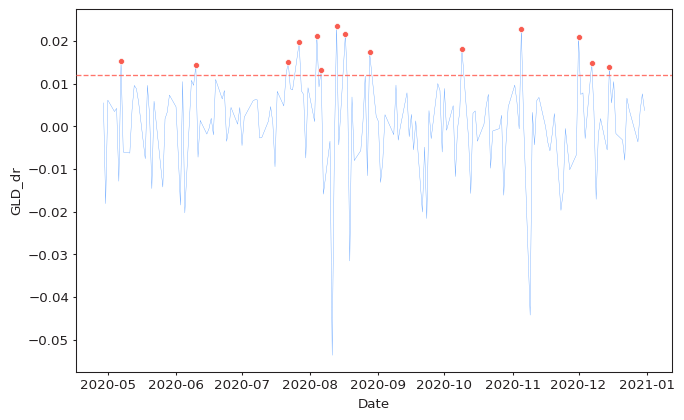

In [46]:
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
GLD_extremes_high = get_extremes(data['GLD_dr'], "POT", threshold=get_threshold_range(data['GLD_dr'])[0], r="24H")
plot_extremes(
    ts=data['GLD_dr'],
    extremes=GLD_extremes_high,
    extremes_method="POT",
    extremes_type="high",
    threshold=get_threshold_range(data['GLD_dr'])[0],
)
GLD_extremes_high

Lower extremes

Date
2020-08-11   -0.053694
2020-11-09   -0.044271
Name: GLD_dr, dtype: float64

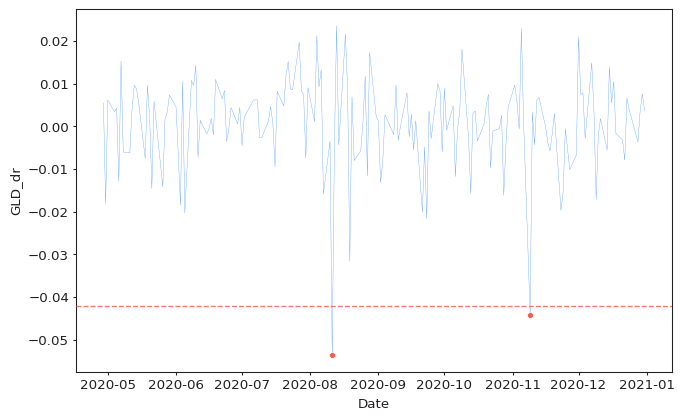

In [47]:
GLD_extremes_low = get_extremes(data['GLD_dr'], "POT", threshold=get_threshold_range(data['GLD_dr'])[1], extremes_type = "low", r="24H")
plot_extremes(
    ts=data['GLD_dr'],
    extremes=GLD_extremes_low,
    extremes_method="POT",
    extremes_type="low",
    threshold=get_threshold_range(data['GLD_dr'])[1],
)
GLD_extremes_low

##### EEM Extreme Values

Date
2020-04-29    0.029145
2020-05-18    0.039134
2020-07-06    0.043037
2020-11-04    0.031442
Name: EEM_dr, dtype: float64

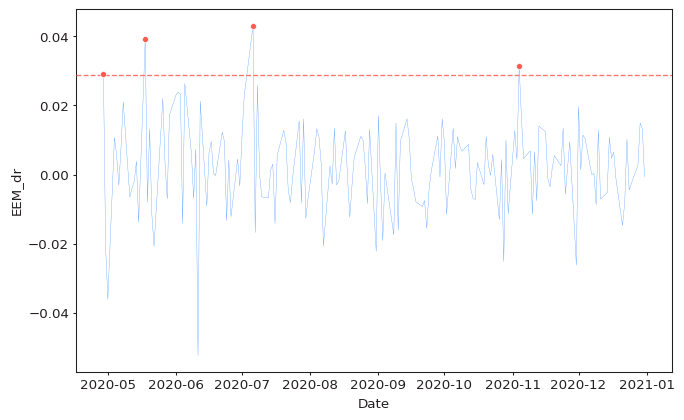

In [48]:
EEM_extremes_high = get_extremes(data['EEM_dr'], "POT", threshold=get_threshold_range(data['EEM_dr'])[0], r="24H")
plot_extremes(
    ts=data['EEM_dr'],
    extremes=EEM_extremes_high,
    extremes_method="POT",
    extremes_type="high",
    threshold=get_threshold_range(data['EEM_dr'])[0],
)
EEM_extremes_high

Date
2020-06-11   -0.052197
Name: EEM_dr, dtype: float64

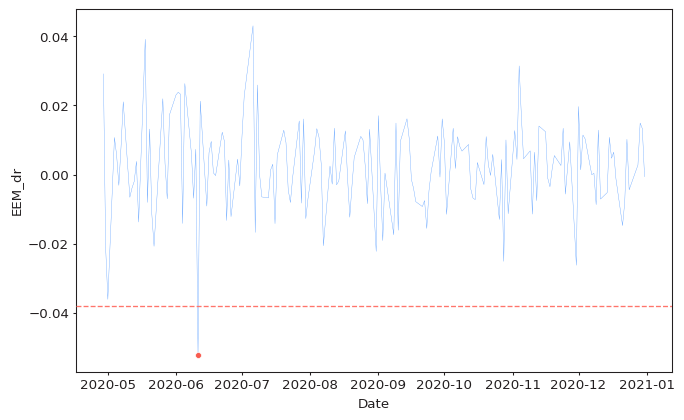

In [49]:
EEM_extremes_low = get_extremes(data['EEM_dr'], "POT", threshold=get_threshold_range(data['EEM_dr'])[1], extremes_type = "low", r="24H")
plot_extremes(
    ts=data['EEM_dr'],
    extremes=EEM_extremes_low,
    extremes_method="POT",
    extremes_type="low",
    threshold=get_threshold_range(data['EEM_dr'])[1],
)
EEM_extremes_low

GBTC Extreme Values

Date
2020-11-30    0.231431
Name: GBTC_dr, dtype: float64

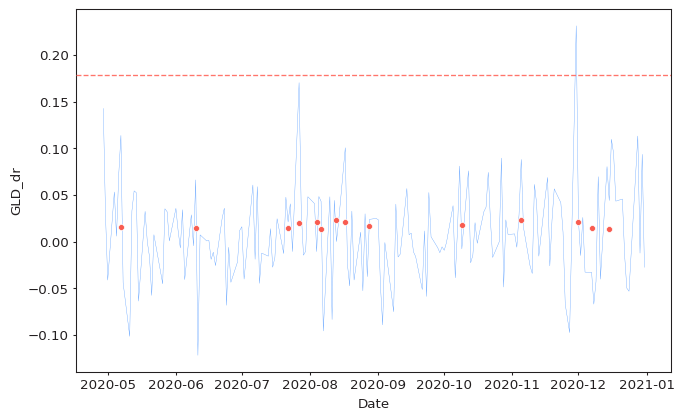

In [50]:
GBTC_extremes_high = get_extremes(data['GBTC_dr'], "POT", threshold=get_threshold_range(data['GBTC_dr'])[0], r="24H")
plot_extremes(
    ts=data['GBTC_dr'],
    extremes=GLD_extremes_high,
    extremes_method="POT",
    extremes_type="high",
    threshold=get_threshold_range(data['GBTC_dr'])[0],
)
GBTC_extremes_high

Date
2020-05-11   -0.101310
2020-06-11   -0.121594
2020-08-07   -0.095568
2020-08-11   -0.083272
2020-09-03   -0.089049
2020-09-08   -0.074938
2020-11-27   -0.097292
Name: GBTC_dr, dtype: float64

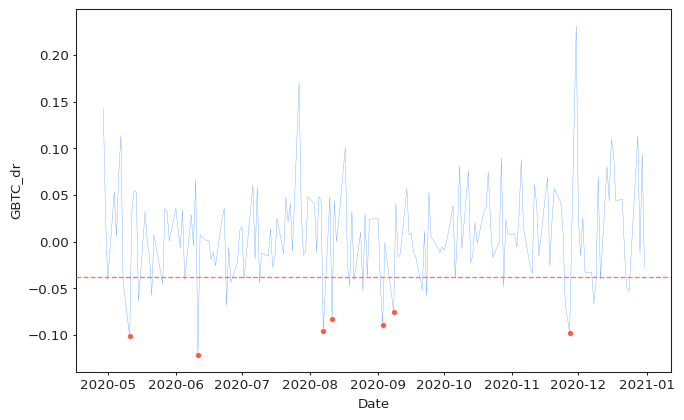

In [51]:
GBTC_extremes_low = get_extremes(data['GBTC_dr'], "POT", threshold=get_threshold_range(data['GBTC_dr'])[1], extremes_type = "low", r="24H")
plot_extremes(
    ts=data['GBTC_dr'],
    extremes=GBTC_extremes_low,
    extremes_method="POT",
    extremes_type="low",
    threshold=get_threshold_range(data['EEM_dr'])[1],
)
GBTC_extremes_low

### Step 4: Data Comparision: Copula


Compare the number of extreme values in each series

In [52]:
print("GLD extreme values count is " + str(len(GLD_extremes_high)+ len(GLD_extremes_low)))
print("EEM extreme values count is " + str(len(EEM_extremes_high)+ len(EEM_extremes_low)))
print("GBTC extreme values count is " + str(len(GBTC_extremes_high)+ len(GBTC_extremes_low)))

GLD extreme values count is 16
EEM extreme values count is 5
GBTC extreme values count is 8


Since GLD and GBTC are the two series with higher extreme value count, we plot them against each other as follow

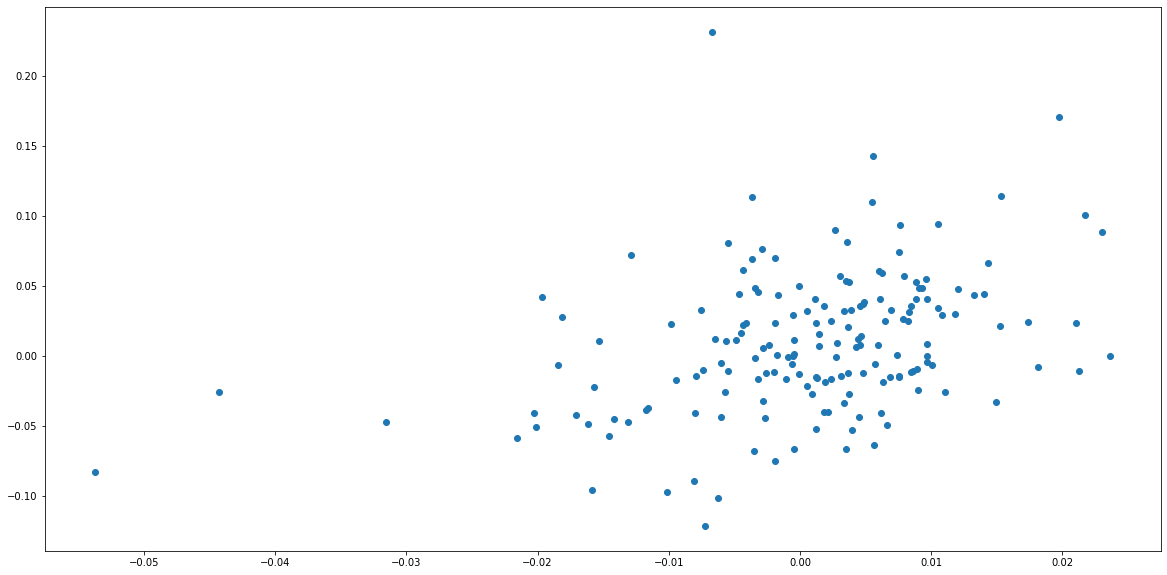

In [53]:
plt.scatter(data['GLD_dr'], data['GBTC_dr'])

We then fit the Clayton copula to the 2 series returns in the following section

In [54]:
!pip install copulae

In [55]:
from copulae.archimedean import ClaytonCopula
cc = ClaytonCopula(dim = 2)
cc.fit(data[['GLD_dr','GBTC_dr']])
cc.summary()

          GLD_dr     GBTC_dr
count  172.00000  172.000000
mean     0.50000    0.500000
std      0.28784    0.287839
min      0.00578    0.005780
25%      0.25289    0.252890
50%      0.50000    0.500000
75%      0.74711    0.747110
max      0.99422    0.994220


Clayton Copula Summary
================================================================================
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 0.5934885170157524

In [56]:
cc.log_lik(data[['GLD_dr','GBTC_dr']])

14.879658111173384

The low log likelihood value implies the fitted model of Clayton Copula with theta parameter ~ 0.59 did not fit the data very well

### Step 5: Category 1 model for GBTC

In [57]:
!pip install backtesting

     |████████████████████████████████| 175 kB 6.8 MB/s 
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173822 sha256=e1b4992b0817c2a300d1df43dfc44a385101bdd0b8337f24e9a2fb7639686690
  Stored in directory: /root/.cache/pip/wheels/48/1d/ea/65dacebc37da7655d8a1fd0f315ac39d102e31d6545237a1c6
Successfully built backtesting


In this section, we conduct ARMA/ GARCH based strategy for GBTC data

#### 1st type: ARMA-based

##### Performance evaluation of GBTC (5.2, 5.3)

In [58]:
!pip install arch

     |████████████████████████████████| 902 kB 7.4 MB/s 


In [59]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 6.9 MB/s 


###### 1st horizon Q2, 2nd horizon Q3

In [60]:
data_q2 = data[Apr20:Jul20]
data_q3 = data[Jul20:Oct20]
data_q4 = data[Oct20:Jan21]

We do a sample ARMA parameter selection based on traditional ACF/PACF plot method here for Q2 just for pedagogical purpose. We will use pmdarima library for ARMA/ GARCH parameter selection for the rest of our implementation

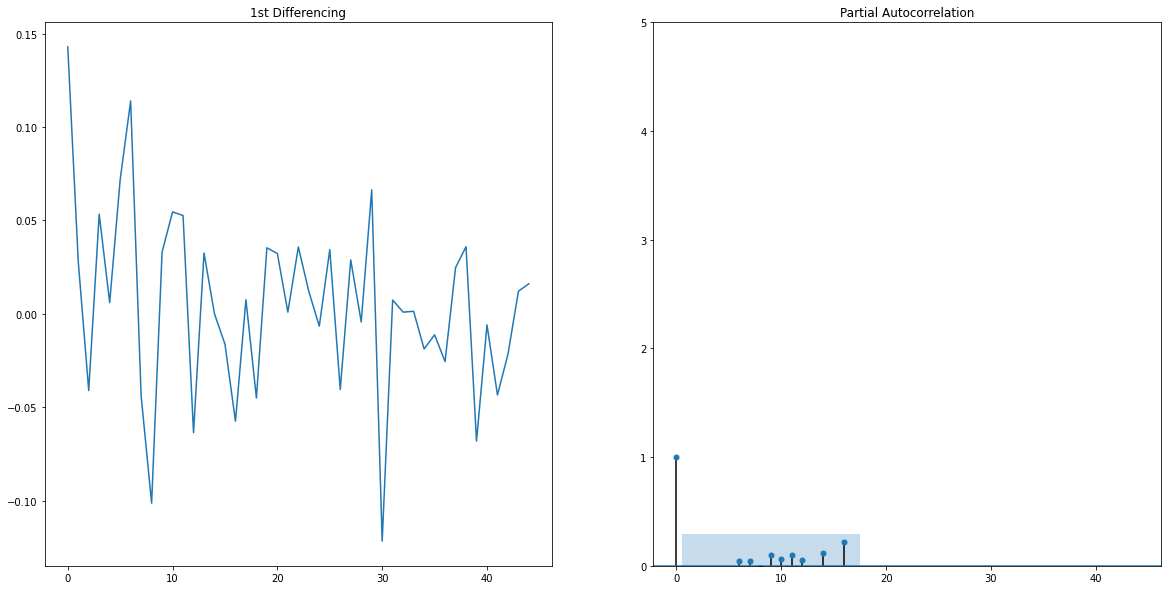

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.DataFrame(data_q2['GBTC_dr']).reset_index(drop=True)
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

Based on the ACF plot, we choose 1 as the order of the AR term

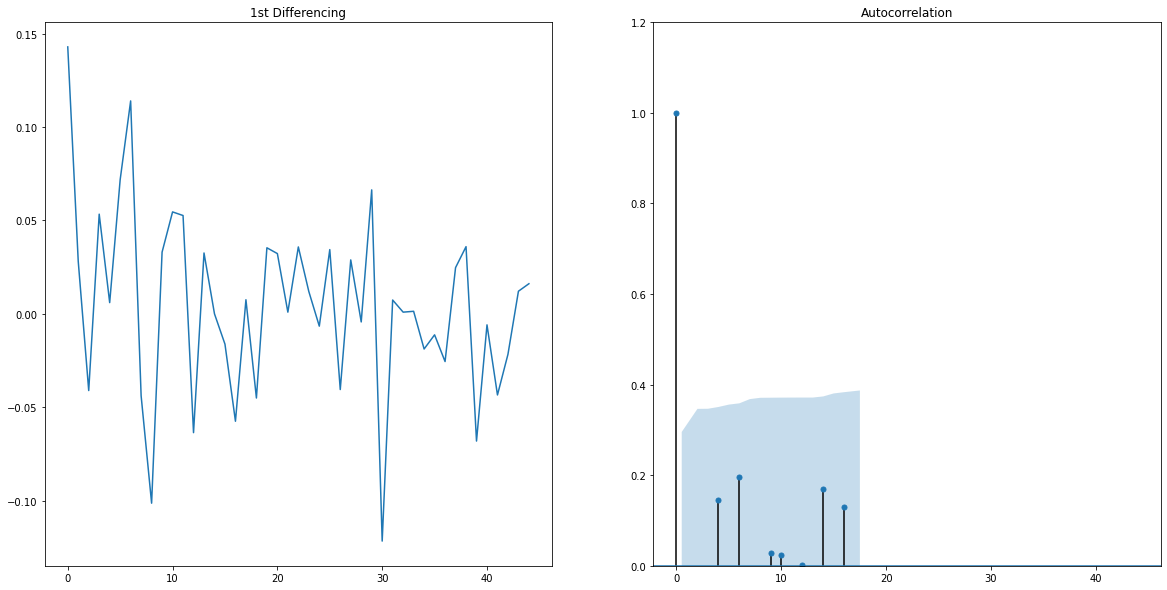

In [63]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.diff().dropna(), ax=axes[1])

plt.show()

Based on the correlation plot, we choose 1 as the MA term

In [245]:
# Forecasting
import pmdarima
def ARMA_fit_predict(fit_period, predict_period):
  arima_model_fitted = pmdarima.auto_arima(fit_period)
  return arima_model_fitted.predict(len(predict_period)), arima_model_fitted.arima_res_.resid
data_q3['GBTC_pp'] = ARMA_fit_predict(data_q2['GBTC_dr'], data_q3['GBTC_dr'])[0]

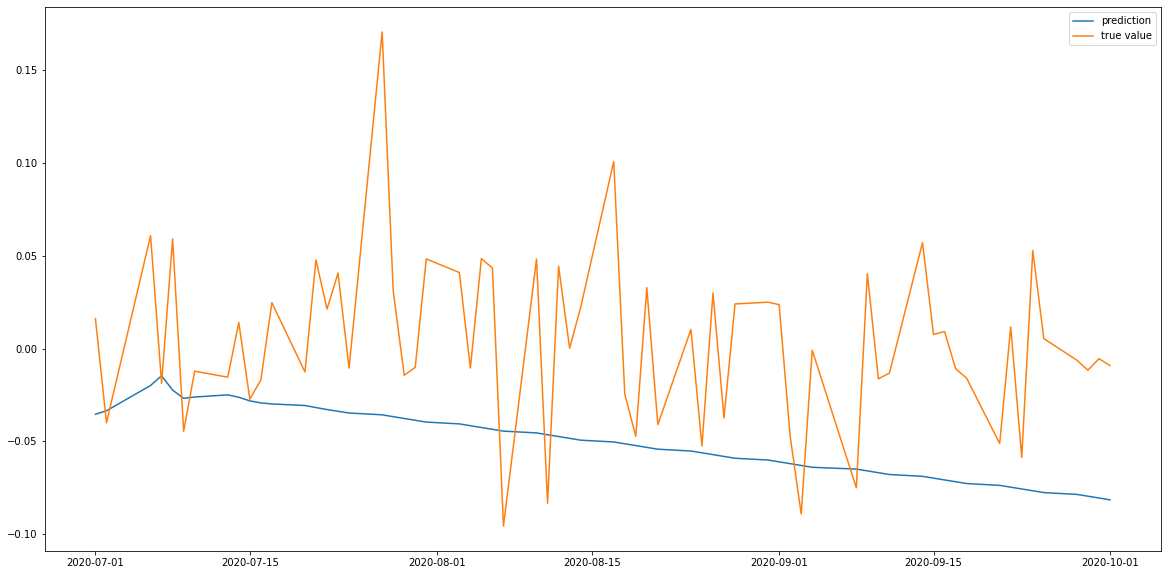

In [246]:
plt.plot(data_q3['GBTC_pp'], label = 'prediction')
plt.plot(data_q3['GBTC_dr'], label = 'true value')
plt.legend()

###### 1st horizon Q3, 2nd horizon Q4

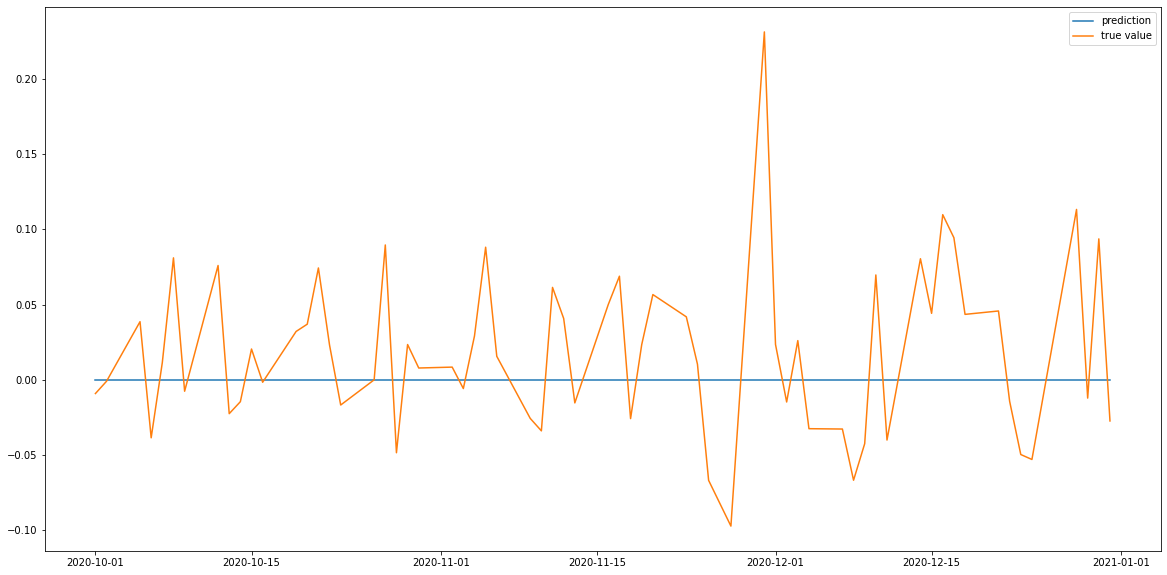

In [247]:
data_q4['GBTC_pp'] = ARMA_fit_predict(data_q3['GBTC_dr'], data_q4['GBTC_dr'])[0]
plt.plot(data_q4['GBTC_pp'], label = 'prediction')
plt.plot(data_q4['GBTC_dr'], label = 'true value')
plt.legend()

##### ARMA trading strategy

Our ARMA strategy is described as follow

*   Train ARMA models over all previous returns (a testing period for 172 days means 171 models)
*   Using ARMA models to predict next day returns
*   If the predicted returns for next day is negative, short the stock. If postive, long the stock
*   To make sure the model has enough training data, we test our method only on Q3 and Q4 data




In [248]:
data_q3_q4 = data[Jul20:Jan21]
data_q3_q4['GBTC_pp'] = [ARMA_fit_predict(data['GBTC_dr'].iloc[0:i-1], data['GBTC_dr'].iloc[i-1:i])[0] for i in range(len(data_q2) -1, len(data))]

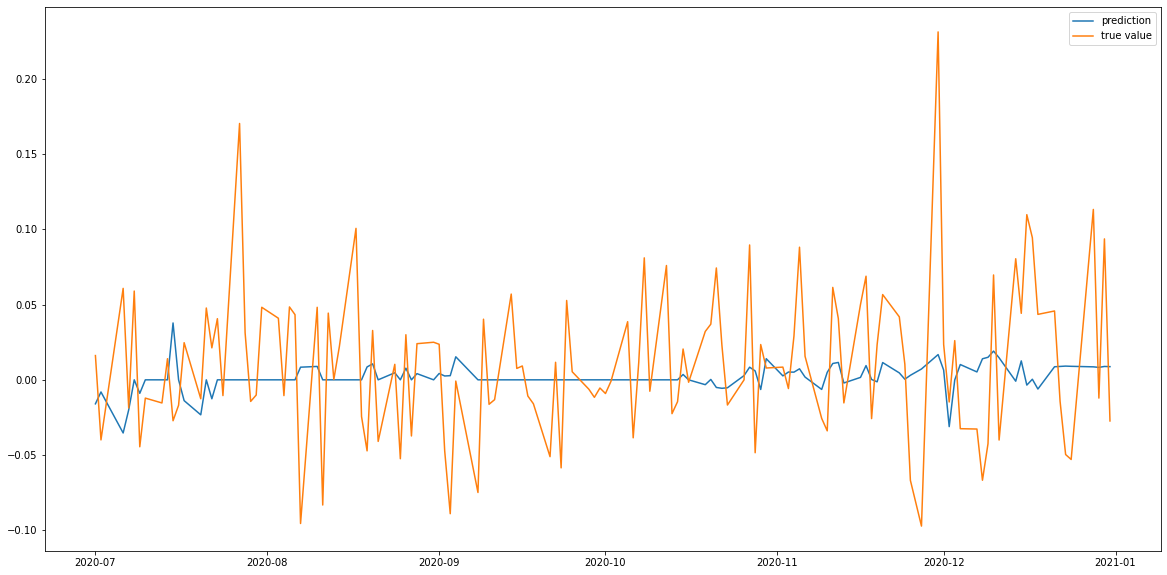

In [249]:
plt.plot(data_q3_q4['GBTC_pp'], label = 'prediction')
plt.plot(data_q3_q4['GBTC_dr'], label = 'true value')
plt.legend()

In [250]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, SignalStrategy

class ARMAS(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data_q3_q4['GBTC_pp'])
bt = Backtest(GBTC[Jul20:Jan21], ARMAS, exclusive_orders=False)
stats = bt.run()
bt.plot()

Row(id='10320', ...)

In [251]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                     98.4375
Equity Final [$]                 10048.250091
Equity Peak [$]                  10080.410087
Return [%]                           0.482501
Buy & Hold Return [%]              227.868845
Return (Ann.) [%]                    0.952144
Volatility (Ann.) [%]                5.738334
Sharpe Ratio                         0.165927
Sortino Ratio                        0.264227
Calmar Ratio                         0.225498
Max. Drawdown [%]                   -4.222404
Avg. Drawdown [%]                   -1.158261
Max. Drawdown Duration      167 days 00:00:00
Avg. Drawdown Duration       45 days 00:00:00
# Trades                                   54
Win Rate [%]                        38.888889
Best Trade [%]                      62.581956
Worst Trade [%]                    -70.793033
Avg. Trade [%]                    

####2nd type: GARCH based
Previous introduced ARMA based trading strategy relies on the predicted conditional mean from ARMA (Equation 1)

$$ y_t = \mu +\sum_{i=1}^p a_iy_{t-i} +\sum_{i=1}^q b_i\epsilon_{t-i} + \epsilon_t(1)$$

However, a fundamental assumption in ARMA is that the time series has constant variance $Var(y) = c$, which is not always met in practice. Here, we adopt GARCH model to model the conditional variance of the ARMA error term $\epsilon_t$, denoted ARMA-GARCH approach

##### Performance evaluation of GBTC (5.2, 5.3)

###### 1st horizon Q2, 2nd horizon Q3

In [222]:
# Forecasting
import pmdarima
def ARMA_GARCH_fit_predict(fit_period, predict_period):
  ar = ARMA_fit_predict(fit_period, predict_period)[0]
  arima_residuals = ARMA_fit_predict(fit_period, predict_period)[1]
  garch = arch.arch_model(arima_residuals, p=1, q=1)
  garch_fitted = garch.fit()
  ga = garch_fitted.forecast(horizon = len(predict_period)).mean.iloc[-1]
  return ar + ga
data_q3['GBTC_pp_g'] = np.array(ARMA_GARCH_fit_predict(data_q2['GBTC_dr'], data_q3['GBTC_dr']))

Iteration:      1,   Func. Count:      6,   Neg. LLF: -71.685083002464
Iteration:      2,   Func. Count:     17,   Neg. LLF: -71.89308022444419
Iteration:      3,   Func. Count:     25,   Neg. LLF: -72.24670380026416
Iteration:      4,   Func. Count:     33,   Neg. LLF: -72.2548409092665
Iteration:      5,   Func. Count:     40,   Neg. LLF: -72.29891685600681
Iteration:      6,   Func. Count:     47,   Neg. LLF: -72.34574948617887
Iteration:      7,   Func. Count:     54,   Neg. LLF: -72.39361306728556
Iteration:      8,   Func. Count:     61,   Neg. LLF: -72.44142941399463
Iteration:      9,   Func. Count:     68,   Neg. LLF: -72.48822446819119
Iteration:     10,   Func. Count:     75,   Neg. LLF: -72.67796836587323
Iteration:     11,   Func. Count:     84,   Neg. LLF: -72.67804937998203
Iteration:     12,   Func. Count:     95,   Neg. LLF: -72.69276899339042
Iteration:     13,   Func. Count:    105,   Neg. LLF: -72.69880852789177
Iteration:     14,   Func. Count:    111,   Neg. LLF: 

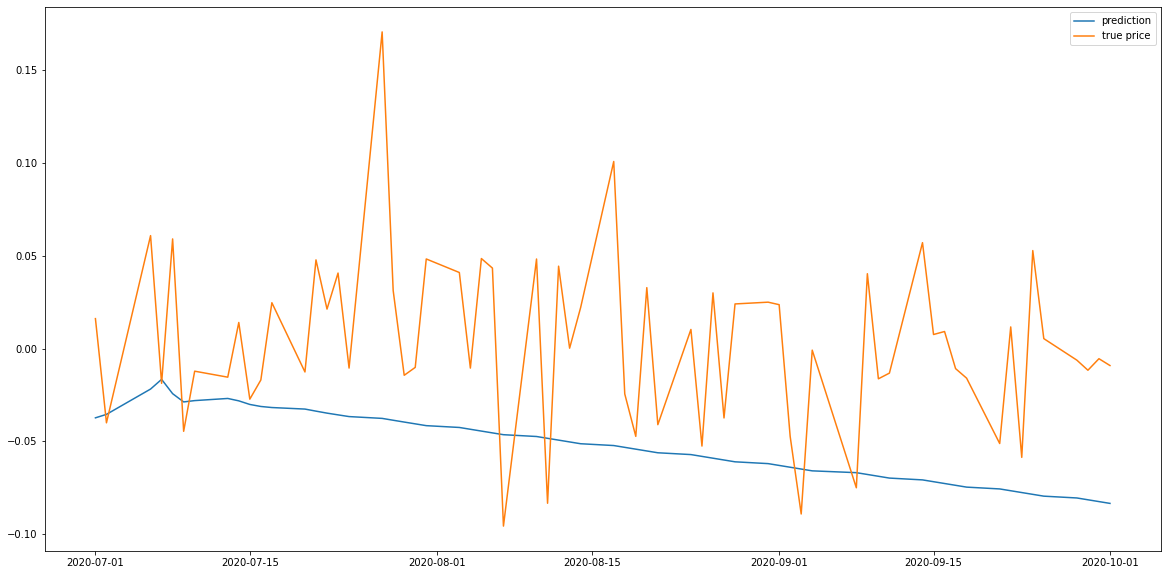

In [223]:
plt.plot(data_q3['GBTC_pp_g'], label = 'prediction')
plt.plot(data_q3['GBTC_dr'], label = 'true value')
plt.legend()

###### 1nd horizon Q3, 2nd horizon Q4

In [224]:
data_q4['GBTC_pp_g'] = np.array(ARMA_GARCH_fit_predict(data_q3['GBTC_dr'], data_q4['GBTC_dr']))

Iteration:      1,   Func. Count:      6,   Neg. LLF: -109.41718716882764
Iteration:      2,   Func. Count:     16,   Neg. LLF: -109.41785629922958
Iteration:      3,   Func. Count:     25,   Neg. LLF: -109.41932190344659
Iteration:      4,   Func. Count:     31,   Neg. LLF: -109.53924100749099
Iteration:      5,   Func. Count:     37,   Neg. LLF: -109.53957608378832
Iteration:      6,   Func. Count:     43,   Neg. LLF: -109.53994776136881
Iteration:      7,   Func. Count:     49,   Neg. LLF: -109.53998969489176
Iteration:      8,   Func. Count:     55,   Neg. LLF: -109.54025190515162
Iteration:      9,   Func. Count:     62,   Neg. LLF: -109.54108315089233
Iteration:     10,   Func. Count:     69,   Neg. LLF: -109.5412732888181
Iteration:     11,   Func. Count:     76,   Neg. LLF: -109.54148534477766
Iteration:     12,   Func. Count:     83,   Neg. LLF: -109.5417070379947
Iteration:     13,   Func. Count:     90,   Neg. LLF: -109.54194249965545
Iteration:     14,   Func. Count:     97

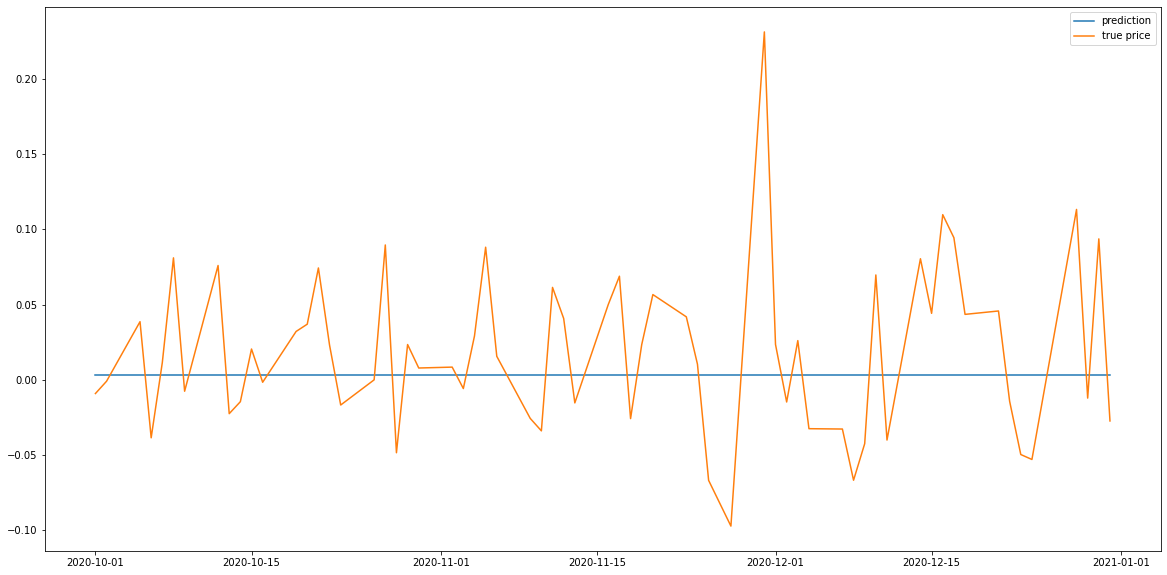

In [226]:
plt.plot(data_q4['GBTC_pp_g'], label = 'prediction')
plt.plot(data_q4['GBTC_dr'], label = 'true value')
plt.legend()

##### GARCH trading strategy

Our ARMA strategy is described as follow

*   Train ARMA-GARCH models over all previous returns (a testing period for 172 days means 171 models)
*   Using ARMA-GARCH models to predict next day returns
*   If the predicted returns for next day is negative, short the stock. If postive, long the stock
*   To make sure the model has enough training data, we test our method only on Q3 and Q4 data



In [228]:
%%capture
data_q3_q4['GBTC_pp_g'] = [ARMA_GARCH_fit_predict(data['GBTC_dr'].iloc[0:i-1], data['GBTC_dr'].iloc[i-1:i])[0] for i in range(len(data_q2) -1, len(data))]

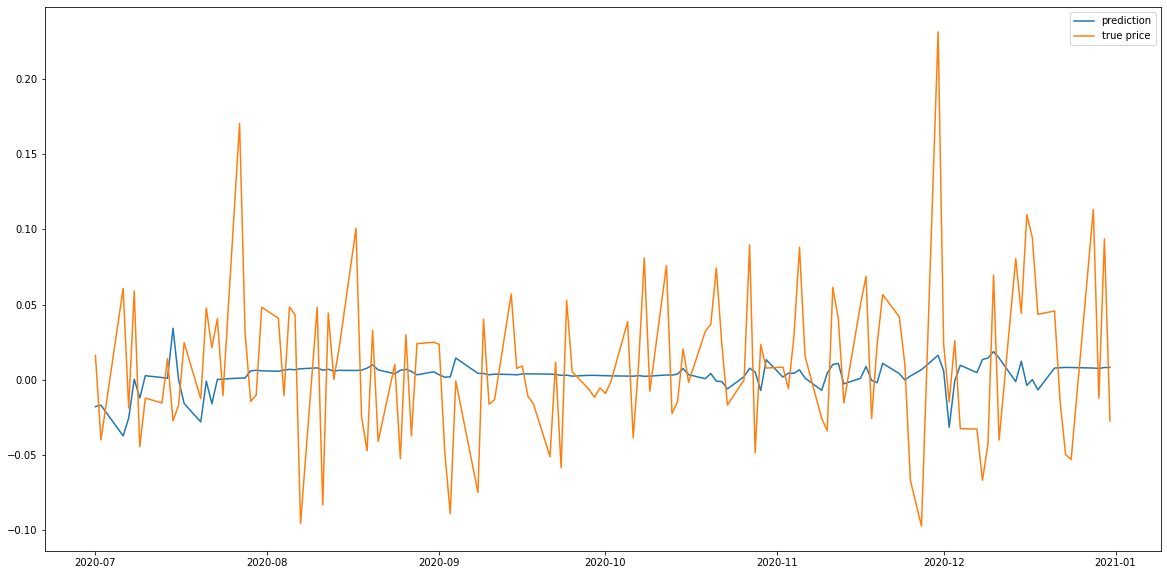

In [229]:
plt.plot(data_q3_q4['GBTC_pp_g'], label = 'prediction')
plt.plot(data_q3_q4['GBTC_dr'], label = 'true value')
plt.legend()

In [230]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, SignalStrategy

class GARCH(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data_q3_q4['GBTC_pp_g'])
bt = Backtest(GBTC[Jul20:Jan21], GARCH, exclusive_orders=False)
stats = bt.run()
bt.plot()

Row(id='8726', ...)

In [231]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                     98.4375
Equity Final [$]                 11775.030231
Equity Peak [$]                  11862.870215
Return [%]                          17.750302
Buy & Hold Return [%]              227.868845
Return (Ann.) [%]                    37.94517
Volatility (Ann.) [%]               19.746298
Sharpe Ratio                         1.921635
Sortino Ratio                        5.440575
Calmar Ratio                         8.053185
Max. Drawdown [%]                   -4.711821
Avg. Drawdown [%]                   -1.625619
Max. Drawdown Duration      112 days 00:00:00
Avg. Drawdown Duration       15 days 00:00:00
# Trades                                  102
Win Rate [%]                        65.686275
Best Trade [%]                     205.014216
Worst Trade [%]                    -52.795036
Avg. Trade [%]                    

Based on the model statistics, it is the case that GARCH outperforms ARMA model on almost all statistical metric 

### Step 6: Category 2 model for GLD and GBTC

#### 1st type: VAR-based

##### Performance evaluation of GLD and GBTC modeling (5.2, 5.3)

###### 1st horizon Q2, 2nd horizon Q3

In [269]:
from statsmodels.tsa.api import VAR
modelQ2 = VAR(data_q2[['GBTC_dr', 'GLD_dr']])
x= modelQ2.select_order()
x.summary()

,AIC,BIC,FPE,HQIC
0,-16.18*,-16.09*,9.370e-08*,-16.15*
1,-16.08,-15.81,1.042e-07,-15.99
2,-15.89,-15.45,1.261e-07,-15.74
3,-15.84,-15.22,1.336e-07,-15.62
4,-15.74,-14.94,1.498e-07,-15.46
5,-15.65,-14.67,1.666e-07,-15.31
6,-15.60,-14.44,1.813e-07,-15.20
7,-15.43,-14.09,2.250e-07,-14.97
8,-15.32,-13.81,2.656e-07,-14.80
9,-15.19,-13.51,3.273e-07,-14.61


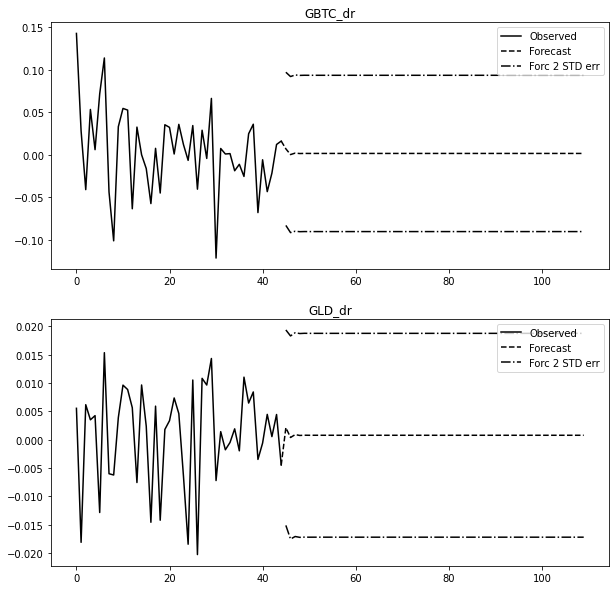

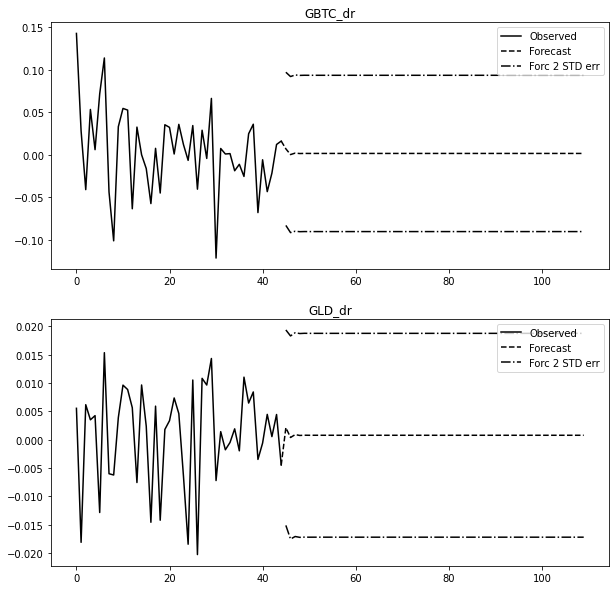

In [271]:
modelQ2_VAR = modelQ2.fit(1)
modelQ2_VAR.plot_forecast(steps=len(data_q3), plot_stderr= True)

###### 1st horizon Q3, 2nd horizon Q4

In [273]:
modelQ3 = VAR(data_q3[['GBTC_dr', 'GLD_dr']])
x= modelQ3.select_order()
x.summary()

,AIC,BIC,FPE,HQIC
0,-15.20*,-15.13*,2.495e-07*,-15.18*
1,-15.12,-14.90,2.706e-07,-15.04
2,-15.05,-14.69,2.901e-07,-14.91
3,-14.93,-14.41,3.305e-07,-14.73
4,-14.91,-14.25,3.359e-07,-14.66
5,-14.80,-13.99,3.779e-07,-14.49
6,-14.86,-13.91,3.574e-07,-14.49
7,-14.80,-13.70,3.832e-07,-14.38
8,-14.68,-13.43,4.390e-07,-14.20
9,-14.56,-13.16,5.079e-07,-14.02


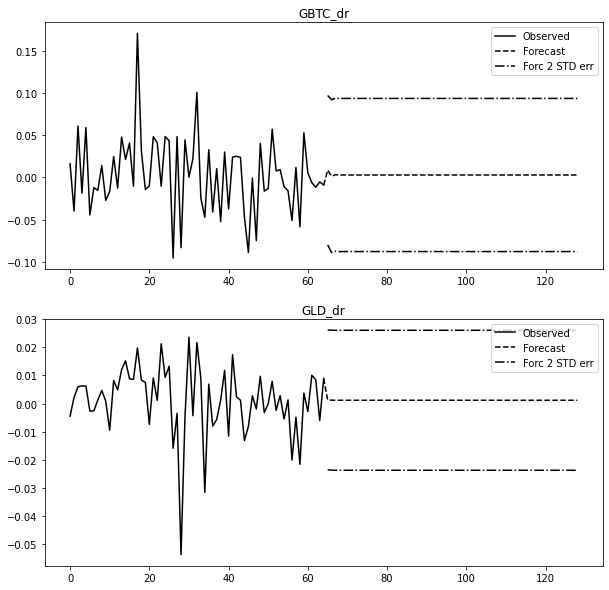

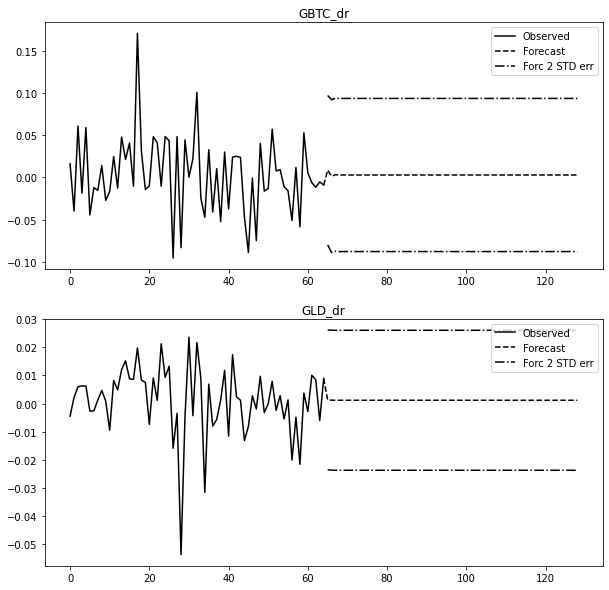

In [274]:
modelQ3_VAR = modelQ3.fit()
modelQ3_VAR.plot_forecast(steps=len(data_q4), plot_stderr= True)

##### VAR trading strategy

Our ARMA strategy is described as follow

*   Train VAR models over all previous returns on both GBTC and GLD (a testing period for 172 days means 171 models)
*   Using VAR to predict next day returns of GBTC and GLD ($r_{1}$ and $r_{2}$)
*   If the predicted returns for asset $\alpha$ next day is negative, short the stock with $\frac{\mid r_{\alpha} \mid}{\mid r_1 \mid + \mid r_2 \mid}$ of the portfolio. If postive, long the stock with the same ratio
*   To make sure the model has enough training data, we test our method only on Q3 and Q4 data



In [261]:
!pip install epymetheus

     |████████████████████████████████| 109 kB 6.5 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [399]:
def VAR_fit_predict(fit_period):
  modelQ3 = VAR(fit_period)
  modelQ3_VAR = modelQ3.fit(maxlags=15, ic='aic')
  lag_order = modelQ3_VAR.k_ar
  return modelQ3_VAR.forecast(fit_period.values[-lag_order:], steps = 1)
VAR_fit_predict(data[['GBTC_dr', 'GLD_dr', 'GLD']].iloc[0:30])

LinAlgError: ignored

In [406]:
data_q3_q4['GBTC_pp_v'] = [VAR_fit_predict(data[['GBTC_dr', 'GLD_dr', 'GLD']].iloc[0:i-1]) for i in range(len(data_q2) -1, len(data))]

ValueError: ignored

In [308]:
modelQ3 = VAR(data_q3[['GBTC_dr', 'GLD_dr']])
modelQ3_VAR = modelQ3.fit()
modelQ3_VAR.forecast(np.random(2), steps = 1)

TypeError: ignored

In [374]:
data_q3_q4

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr,GLD_dr,EEM_dr,GBTC_dr,EEM_MA20,GLD_MA20,GBTC_MA20,GBTC_pp
Date,,,,,,,,,,,,,
2020-07-01,39.268055,166.619995,9.760000,-0.004491,0.011190,0.016009,-0.004481,0.011253,0.016138,38.951391,163.634499,10.69300,[-0.01595947543308064]
2020-07-02,40.161396,166.979996,9.370000,0.002158,0.022495,-0.040779,0.002161,0.022750,-0.039959,39.034899,163.919498,10.57500,[-0.00807396574239189]
2020-07-06,41.889809,167.979996,9.940000,0.005971,0.042136,0.059054,0.005989,0.043037,0.060832,39.154143,164.417999,10.50925,[-0.03535215928919181]
2020-07-07,41.190670,169.039993,9.754000,0.006290,-0.016831,-0.018890,0.006310,-0.016690,-0.018712,39.226363,164.883998,10.41795,[-0.01999958368058917]
2020-07-08,42.258801,170.089996,10.330000,0.006192,0.025601,0.057375,0.006212,0.025931,0.059053,39.365505,165.325498,10.35795,[0.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,49.180485,176.350006,27.350000,0.003977,-0.004379,-0.054433,0.003985,-0.004369,-0.052978,49.122984,173.235500,24.42320,[0.00898950742640847]
2020-12-28,49.317837,175.710007,30.450001,-0.003636,0.002789,0.107369,-0.003629,0.002793,0.113346,49.159384,173.631501,25.00395,[0.008638148694046638]
2020-12-29,50.053627,176.350006,30.080000,0.003636,0.014809,-0.012226,0.003642,0.014919,-0.012151,49.296175,174.115501,25.34825,[0.008271387077138193]
